## Задание 1

### Текст задания:
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

import requests
from urllib.parse import urlencode

from scipy.stats import chi2_contingency
import pingouin as pg
from scipy.stats import levene
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

### Загружаем данные и проводим предобработку

In [13]:
def get_data_from_Yandex_disk(url, sep):
    """ 
    Возвращает df из файла с .csv-расширением, хранящегося на Яндекс-диске,
    url - путь на Яндекс-диск,
    sep - разделитель в файле csv
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
       
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    df = pd.read_csv(download_url, sep=sep)
    return df

In [14]:
auth_data = get_data_from_Yandex_disk('https://disk.yandex.ru/d/KLGQxujRmAc3dQ', sep=';')

##### Приводим даты в нужный формат.

In [16]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [17]:
auth_data.shape

(9601013, 2)

In [18]:
auth_data.uid.value_counts()

2          1929
108        1397
158        1367
176        1331
191        1296
           ... 
420829        1
420830        1
420832        1
420835        1
1110622       1
Name: uid, Length: 1000000, dtype: int64

In [19]:
auth_data.uid.nunique()

1000000

In [20]:
auth_data['auth_ts'] = auth_data['auth_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

In [21]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], format='%Y-%m-%d')

In [22]:
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [23]:
reg_data = get_data_from_Yandex_disk('https://disk.yandex.ru/d/V38QVEg9ioeAyg', sep=';')

In [24]:
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [25]:
reg_data['reg_ts'] = reg_data['reg_ts'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

In [26]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], format='%Y-%m-%d')

In [27]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

### Объединяем данные в одну таблицу и отбираем за последние 2 недели
т.к. более ранние данные в контексте нашей задачи уже потеряли актуальность

In [28]:
all_data = auth_data.merge(reg_data, how='left', on='uid', copy=True)

In [29]:
data_for_analysis = all_data.query('reg_ts >= "2020-09-10"')

### Когортный анализ / Визуализация

In [31]:
def Cohort_analysis(df):
    # отфильтруем массив так, чтобы визуально контролировать правильность дальнейших действий
    df.sort_values(['uid', 'auth_ts'], inplace=True)
    
    # Сначала расчитаем добавим дату первой авторизации в df
    first_auth = df.groupby('uid', as_index=False) \
                   .agg({'auth_ts': 'min'}) \
                   .rename(columns={'auth_ts': 'first_auth'})
    data_for_analysis_merged = df.merge(first_auth, how='left', on='uid')
    # Переименуем колонки для удобства
    data_for_analysis_merged.rename(columns={'auth_ts': 'authorisation_date', 'reg_ts': 'regist_date'}, inplace=True)
    
    # Строим когорты. Когорты - игроки, сделавшие первую авторизацию в тот или иной день. 
    # Целевая метрика - количество авторизаций 
    cohorts = data_for_analysis_merged.groupby(['regist_date', 'authorisation_date'], as_index=False) \
                                      .agg({'uid': 'nunique', 
                                            'first_auth': 'count'}) \
                                      .rename(columns={'uid': 'total_users',
                                                       'first_auth': 'total_first_auth'})
    # Считаем период
    cohorts['cohort_period'] = cohorts.authorisation_date - cohorts.regist_date
    
    # считаем retention
    # сначала переиндексируем df и создадим ряд содержаший размер каждой когорты regist_date
    cohorts.set_index(['cohort_period', 'regist_date'], inplace=True)
    cohort_group_size = cohorts['total_users'].groupby(level=1).first()
    
    user_ret = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=0)
    
    # Блок визуелизации
    sns.set(style='ticks')
    plt.figure(figsize=(24, 16))
    plt.title('Cohorts: User Retention')
    plt.xlabel('Cohort Period')
    plt.ylabel('Date of registration')
 
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   # labels for x-axis
    y = cohorts.reset_index().regist_date.dt.strftime('%m/%d/%Y').unique()   # labels for y-axis

    sns.heatmap(user_ret, 
                mask=user_ret.isnull(), 
                annot=True, 
                fmt='.0%', 
                linewidths=.5,
                cmap="YlGnBu",
                vmin=0,
                vmax=0.2,
                xticklabels=x,
                yticklabels=y)
          
    return user_ret

C:\Users\Nata\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


cohort_period,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,11 days,12 days,13 days
regist_date,,,,,,,,,,,,,,
2020-09-10,1.0,0.013673,0.044127,0.051585,0.049720,0.064636,0.062772,0.062150,0.054071,0.041019,0.058421,0.050963,0.049099,0.039776
2020-09-11,1.0,0.013656,0.038485,0.039106,0.057728,0.063315,0.073867,0.057107,0.043451,0.044693,0.051521,0.063315,0.043451,NaN
2020-09-12,1.0,0.018587,0.042751,0.043990,0.039653,0.062577,0.069393,0.060099,0.050186,0.048327,0.048327,0.034696,NaN,NaN
2020-09-13,1.0,0.022277,0.043936,0.040223,0.052599,0.062500,0.068688,0.050124,0.052599,0.051980,0.052599,NaN,NaN,NaN
2020-09-14,1.0,0.017901,0.036420,0.037654,0.056173,0.059877,0.067284,0.066667,0.040123,0.037654,NaN,NaN,NaN,NaN
2020-09-15,1.0,0.023428,0.045006,0.040691,0.063502,0.054871,0.070284,0.056104,0.035142,NaN,NaN,NaN,NaN,NaN
2020-09-16,1.0,0.022167,0.043103,0.043719,0.052956,0.066502,0.078202,0.040640,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-17,1.0,0.020270,0.038084,0.040541,0.058354,0.055283,0.060811,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-18,1.0,0.021472,0.039877,0.044172,0.046012,0.054601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


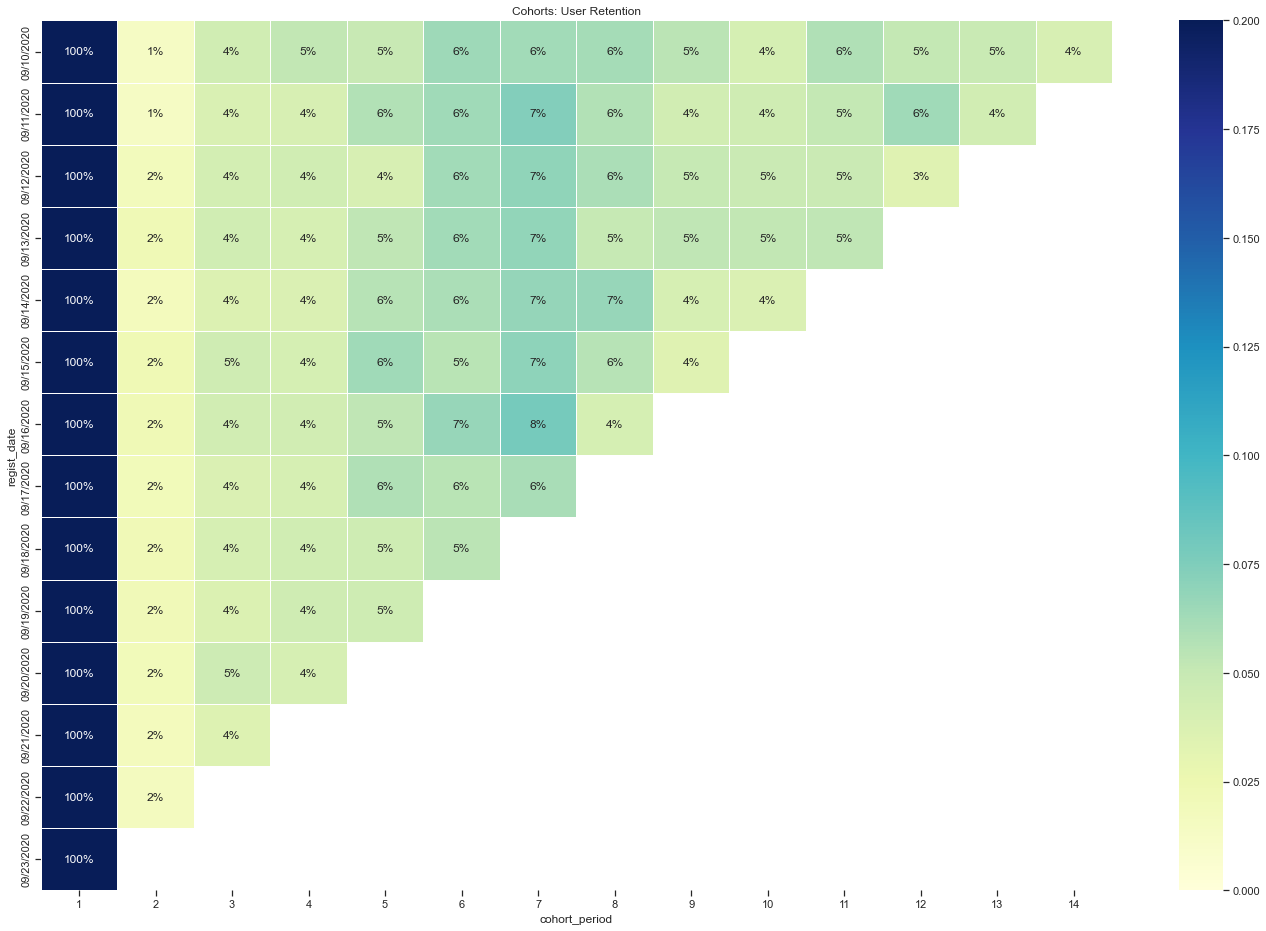

In [32]:
Cohort_analysis(data_for_analysis)

## Задание 2

### Текст задания:
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1 928 игроков из 202 103 оказались платящими, а в тестовой – 1 805 из 202 667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [111]:
from scipy.stats import chi2_contingency
import pingouin as pg
from scipy.stats import levene
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import ttest_ind

In [34]:
df = get_data_from_Yandex_disk('https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';')

In [35]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Цель проведения A/B-теста - улучшение целевых метрик, при сохранении необходимого уровня остальных метрик. 
Для оценки эффективности той или иной акции используется 2 группы метрик: количественные и доходные.

**Под количественными метриками** мы в данном случае можем понимать долю платящих клиентов.

**Когда речь идет о метриках, связанных с монетизацией,** обычно имеют в виду следующие: Общий доход (Revenue) и средние величины: ARPU, ARPPU, средний или медианный чеки.


Для начала проведем первичную оценку данных, проверим их на наличие выбросов и аномалий.

In [36]:
df.shape

(404770, 3)

In [37]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [38]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [39]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

Разделим данные для удобства анализа на 2 группы: тестовую и контрольную, при этом оставив в выбоках только платящих пользователей, поскольку интересуют нас, в первую очередь, они.

In [40]:
df_control = df.query('testgroup == "a" and revenue > 0')

In [41]:
df_test = df.query('testgroup == "b" and revenue > 0')

Проведем анализ данных пользователей, попавших в тестовую группу

In [42]:
df_control['revenue'].describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

<AxesSubplot:>

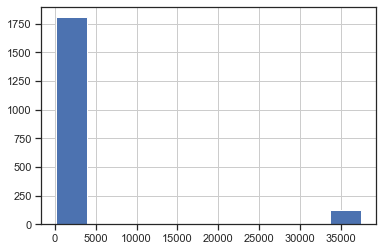

In [43]:
df_control.revenue.hist()

Удаляем выбросы из контрольной группы

In [44]:
df_control_modified = df_control.query('revenue < 30000')

In [45]:
df_control_modified['revenue'].describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

<AxesSubplot:>

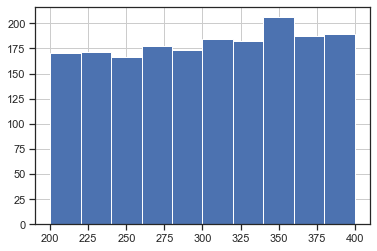

In [46]:
df_control_modified.revenue.hist()

<AxesSubplot:ylabel='revenue'>

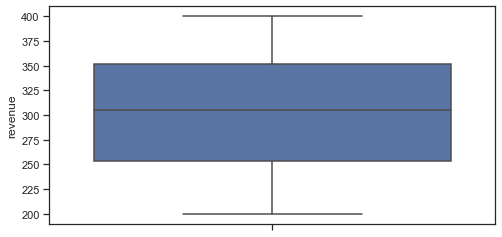

In [47]:
plt.figure(figsize=(8, 4))
sns.boxplot(y='revenue', data=df_control_modified)

In [48]:
df_test.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


<AxesSubplot:>

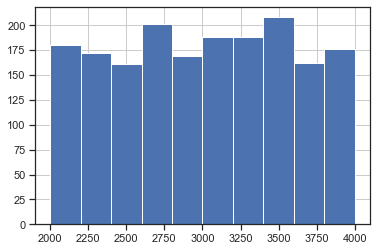

In [49]:
df_test.revenue.hist()

<AxesSubplot:ylabel='revenue'>

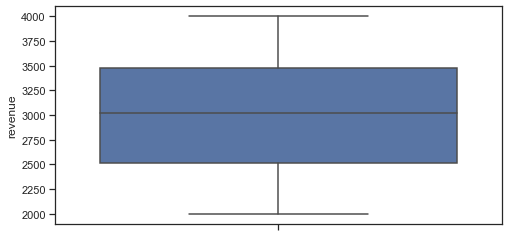

In [50]:
plt.figure(figsize=(8, 4))
sns.boxplot(y='revenue', data=df_test)

In [51]:
data = df.query('revenue > 0 and revenue < 30000').groupby('testgroup', as_index=False).agg({'revenue': 'median'})

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

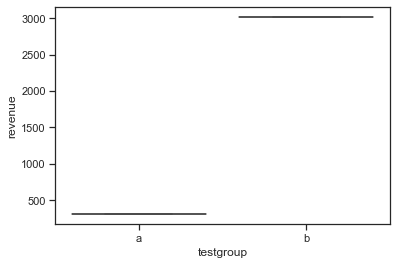

In [52]:
sns.boxplot(x='testgroup', y='revenue', data=data)

Как мы видим из боксплотов, различия между медианными значениями существенны 

In [53]:
df.query('revenue > 0 and revenue < 30000').groupby('testgroup', as_index=False).agg({'revenue': 'median'})

,testgroup,revenue
0,a,305.0
1,b,3022.0


#### Конверсия. 

С помощью критерия согласия Пирсона проверим, значимы ли различия между группами в доле платящих пользователей. **Н0 =** наблюдаемые частоты соответствуют ожидаемым
**Н1 =** наблюдаемые частоты в группах отличаются от ожидаемых. 
Для этого составим таблицу сопряженности:

In [54]:
# вычислим количество платящих пользователей
paying_customers = df.query('revenue > 0 and revenue < 30000') \
                     .groupby('testgroup', as_index=False) \
                     .agg({'user_id': 'count'})

In [55]:
# вычислим количество не платящих пользователей
non_paying_customers = df.query('revenue < 30000').groupby('testgroup', as_index=False).agg({'user_id': 'count'})

In [56]:
# составим таблицу сопряженности
df_for_analysis = non_paying_customers.merge(paying_customers, how='left', on='testgroup') \
                                      .rename(columns={'user_id_x': 'non_paying_cust', 'user_id_y': 'paying_cust'}) \
                                      .set_index('testgroup')

In [57]:
df_for_analysis

,non_paying_cust,paying_cust
testgroup,,
a,201980,1805
b,202667,1805


In [58]:
df_for_analysis.values

array([[201980,   1805],
       [202667,   1805]], dtype=int64)

**Проведем тестирование**

In [59]:
chi, pvalue, k, _ = chi2_contingency(df_for_analysis.values)

In [60]:
chi

0.007197557957172926

In [61]:
pvalue

0.9323898467843289

In [62]:
k

1

##### Вывод:
Гипотеза об однородности выборок не отвергается. Таким образом, мы можем сказать, что **в результате проведенного теста, количество платящих пользователей значимо не изменилось**

### Метрики дохода

До начала эксперимента необходимо определить объем выборки, достаточный для того, чтобы различия между метриками были статистически значимы. В данном задании ничего не говорится о том, какое изменение целевых метрик будет призначаться значимым. Т.к. в нашем случае нам целевое изменение не известно, мы можем вычислить какова чувствительность у проведенного теста, при имеющихся объемах выборок, power=0.90 и уровне значимости 5%.

In [63]:
# размер выборки контрольной группы
nx = df.query('revenue < 30000 and testgroup == "a"').shape[0]

In [64]:
# размер выборки тестовой группы
ny = df.query('revenue < 30000 and testgroup == "b"').shape[0]

In [65]:
pg.power_ttest2n(nx=nx, ny=ny, power=0.90, alpha=0.05, alternative='greater')

0.009200843580902451

**Вывод:**
При заданной мощности и объеме выборок, мы можем отследить изменения показателей менее 1%.

### ARPU

Для того, чтобы расчитать ARPU, нам нужны все данные, по платящим и неплатящим пользователям, но без выбросов, которые было решено в анализе не учитывать.

In [66]:
# Считаем ARPU без выбросов
ARPU_by_groups = df.query('revenue < 30000') \
                   .groupby('testgroup', as_index=False) \
                   .agg({'revenue': 'mean'}) \
                   .rename(columns={'revenue': 'mean'})
ARPU_by_groups

,testgroup,mean
0,a,2.702926
1,b,26.751287


In [67]:
control_group_ARPU = df.query('revenue < 30000 and testgroup == "a"').revenue

In [68]:
test_group_ARPU = df.query('revenue < 30000 and testgroup == "b"').revenue

<AxesSubplot:>

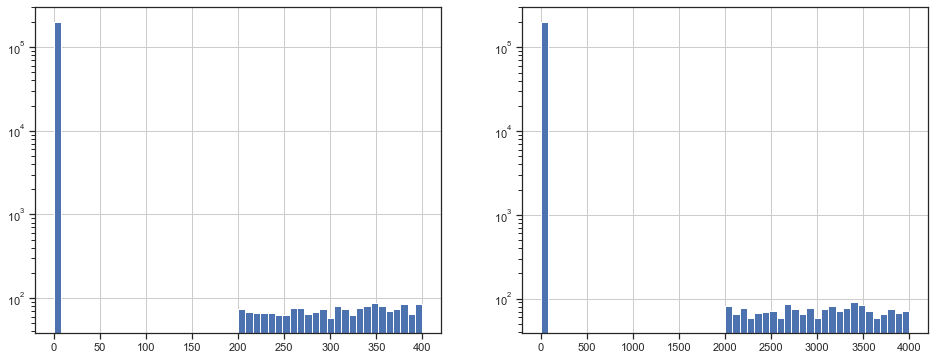

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
control_group_ARPU.hist(bins=50, log=True, ax=axes[0])
test_group_ARPU.hist(bins=50, log=True, ax=axes[1])

Т.к. ARPU фактически является средним значение в выборке, мы можем применить парный t-тест для их сравнения. Однако, его можно применять при выполнении следующих требований:
1. требование гомогенности дисперсий. Проверяем с помощью критерия Левена
2. требование к нормальности данных обеих групп. Хотя все понятно визуально, но применим тест Шапиро-Уилка для определения нормальности распределения.

In [70]:
# Запускаем тест Левена
stat, p = levene(control_group_ARPU, test_group_ARPU)

In [71]:
p

4.912187546515184e-306

**Вывод:** Результаты теста Левина позволяют опровергнуть нулевую гипотезу о равенстве дисперсий.

In [72]:
# сэмплируем выборку для тестовой группы
test_sample = test_group_ARPU.sample(1000, random_state=17)

In [73]:
# Запускаем тест Шапиро_Уилка для тестовой группы
stats.shapiro(test_sample)

ShapiroResult(statistic=0.06715953350067139, pvalue=0.0)

In [74]:
# сэмплируем выборку для контрольной группы
control_sample = control_group_ARPU.sample(1000, random_state=17)

In [75]:
# Запускаем тест Шапиро_Уилка для контрольной группы
stats.shapiro(control_sample)

ShapiroResult(statistic=0.09302335977554321, pvalue=0.0)

**Вывод:** Мы отклоняем нулевую гипотезу о том, что тестовая и контрольная выборки распределены нормально

Итак, оба условия для проведения t-теста не выполняются.
В этом случае, мы можем применять непараметрический тест Манна-Уитни или использовать симуляцию. В силу трудной интерпретации результатов проведения теста Манна-Уитни, мы будем прибегать к симуляции для оценки значимости имеющихся различий, с помощью bootstrap.

In [76]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    test_group_ARPU,   # числовые значения первой выборки
    control_group_ARPU,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.mean,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(test_group_ARPU), len(control_group_ARPU)])
    boot_data = []
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = test_group_ARPU.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = control_group_ARPU.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))   # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

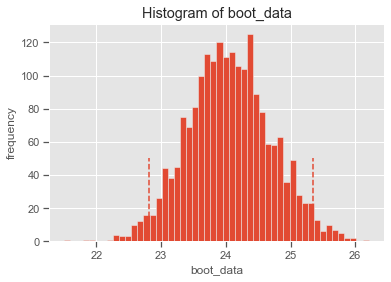

In [80]:
booted_data = get_bootstrap(test_group_ARPU, control_group_ARPU, boot_it=2000)

In [81]:
booted_data["p_value"]

7.99031332822867e-304

In [82]:
booted_data["ci"]

,0
0.025,22.818428
0.975,25.347898


##### Вывод: 
**ARPU** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

### ARPPU

Для того, чтобы расчитать ARPU, нам нужны данные по платящим пользователям, но без выбросов, которые было решено в анализе не учитывать.

In [83]:
ARPPU_by_groups = df.query('revenue > 0 and revenue < 30000') \
                    .groupby('testgroup', as_index=False) \
                    .agg({'revenue': 'mean'}) \
                    .rename(columns={'revenue': 'mean'})
ARPPU_by_groups

,testgroup,mean
0,a,302.458172
1,b,3003.658172


Посмотрим гистограмму распределений величин

<AxesSubplot:>

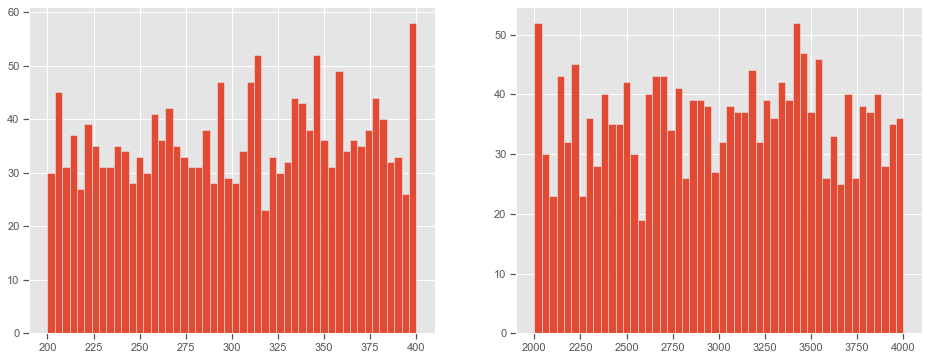

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df_control_modified.revenue.hist(bins=50, ax=axes[0])
df_test.revenue.hist(bins=50, ax=axes[1])

In [85]:
df_test.revenue

160       3797
377       3768
386       3527
551       2038
913       3902
          ... 
403843    3383
403994    2793
404161    2316
404193    2998
404525    3120
Name: revenue, Length: 1805, dtype: int64

Как мы видим, распределение не является нормальным

Т.к. ARPPU фактически является средним значение в выборке, мы можем применить аналогичный порядок действий, который применяли по отношению к ARPU.
Порядок действий:
1. проверка на соответствие требованию гомогенности дисперсий. Проверяем с помощью критерия Левена
2. проверка на соответствие требованию к нормальности данных обеих групп. Хотя все понятно визуально, но применим тест Шапиро-Уилка для определения нормальности распределения
3. парный t-тест для сравнения, если предыдущие условия выполняются.

In [86]:
# Запускаем тест Левена
stat, p = levene(df_control_modified.revenue, df_test.revenue)

In [87]:
p

0.0

**Вывод:** Результаты теста Левина позволяют опровергнуть нулевую гипотезу о равенстве дисперсий.

In [88]:
# сэмплируем выборку для контрольной группы
control_sample = df_control_modified.revenue.sample(1000, random_state=17)

In [89]:
# Запускаем тест Шапиро-Уилка для контрольной группы
stats.shapiro(control_sample)

ShapiroResult(statistic=0.9577839374542236, pvalue=2.1956142196103692e-16)

In [90]:
# сэмплируем выборку для тестовой группы
test_sample = df_test.revenue.sample(1000, random_state=17)

In [91]:
# Запускаем тест Шапиро-Уилка для контрольной группы
stats.shapiro(test_sample)

ShapiroResult(statistic=0.9613319039344788, pvalue=1.2883664412895895e-15)

**Вывод:** Мы отклоняем нулевую гипотезу о том, что тестовая и контрольная выборки распределены нормально

В этом случае, мы можем применять непараметрический тест Манна-Уитни или использовать симуляцию. В силу трудной интерпретации результатов проведения теста Манна-Уитни, мы будем прибегать к симуляции для оценки значимости имеющихся различий, с помощью bootstrap.

In [92]:
df_control_modified = df_control_modified.revenue

In [93]:
df_test = df_test.revenue

In [94]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    df_test,   # числовые значения первой выборки
    df_control_modified,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.mean,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(df_test), len(df_control_modified)])
    boot_data = []
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = df_test.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = df_control_modified.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))   # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

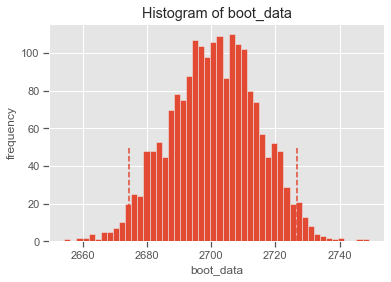

In [95]:
booted_data = get_bootstrap(df_test, df_control_modified, boot_it=2000)

In [96]:
booted_data["p_value"]

0.0

In [97]:
booted_data["ci"]

,0
0.025,2674.483989
0.975,2726.626981


**ARPPU** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

### Средний (медианный) чек

При анализе предоставленных данных мы могли пойти по другому пути, и рассмотреть в качестве целевой метрики рассмотреть медианный чек. При этом, мы можем не удалять их данных выбросы, т.к. в некоторых случаях они могут быть значимыми для анализа.
В этом случае, мы могли бы расчитывать только на симуляцию, для построение доверительного интервала для мединаны

In [98]:
df.groupby('testgroup', as_index=False) \
  .agg({'revenue': 'median'}) \
  .rename(columns={'revenue': 'median'})

,testgroup,median
0,a,0.0
1,b,0.0


В целом по выборке, медианное значение равно 0, поэтому уберем из данных информацию о тех пользователях, которые не совершали покупки, но оставим выбросы.

In [99]:
df_control = df.query('testgroup == "a" and revenue > 0').revenue
df_control.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [100]:
df_test = df.query('testgroup == "b" and revenue > 0').revenue
df_test.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Когда мы сравниваем траты пользователей на сервисе, то средний чек может не измениться, но может вырасти число людей, которые тратят больше определенного значения. В качестве такого значения можно взять верхний порог (3 квартиль) - 361 рубль.
Если мы посмотрим на количество людей, которые потратили суммарно 361 рубль и более, то получим следующие результаты:

In [101]:
df.query('revenue > 361') \
  .groupby('testgroup') \
  .agg({'user_id': 'count'})

,user_id
testgroup,
a,481
b,1805


In [102]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    df_control,   # числовые значения первой выборки
    df_test,   # числовые значения второй выборки
    boot_it=1000,   # количество бутстрэп-подвыборок
    statistic=np.median,   # интересующая нас статистика
    bootstrap_conf_level=0.95   # уровень значимости
):
    boot_len = max([len(df_control), len(df_test)])
    boot_data = []
    for i in tqdm(range(boot_it)):   # извлекаем подвыборки
        samples_1 = df_control.sample(
            boot_len, 
            replace=True   # параметр возвращения
        ).values
        
        samples_2 = df_test.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))   # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.median(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

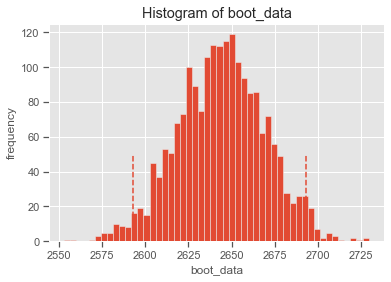

In [103]:
booted_data = get_bootstrap(df_test, df_control, boot_it=2000)

In [104]:
booted_data["p_value"]

0.0

In [105]:
booted_data["ci"]

,0
0.025,2593.0000
0.975,2693.0125


**Медианный чек** в двух выборках значимо отличается, р-value в данном случае меньше уровня значимости 0,05, а в доверительный интервал не попал 0.

## Общие выводы по заданию 2

**Основные гипотезы для анализа результатов теста**

**Нулевая гипотеза.** Все наборы акционных предложений имеют одинаковые показатели платежной эффективности. Другими словами, нет эффекта или нет разницы между разными предложениями.

**Альтернативная гипотеза.** Между наборами акционных предложений есть статистически значимая разница.

### Результаты:
Показатель конверсии (CR) не различается значимо в тестовой контрольной группе. 
ARPU, ARPPU и средний (медианный) чек значимо различаются в тестовой и контрольной группе.
Исходя из этого, мы можем доверять следующим данным:
1. В тестовой группе ARPU выше в 13 раз (без учета выбросов)
2. В тестовой группе ARPPU выше в 10 раз (без учета выбросов)
3. Средний (медианный чек) также выше в 10 раз. 
Метрики дохода значительно выросли, без сокращения конверсии.

Таким образом, мы можем сделать вывод о том, что набор предложений в тестовой группе можно считать лучшим.

## Задание 3

### Текст задания:
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

1. Эффективность проведения тематического события можно оценить исходя из следующих метрик:
   - ASD (Average Session Duration). Эта метрика покажет нам, насколько изменилось среднее время, проведенное в игре до проведения события и после. Если событие было интересным, то ASD увеличится;
   - ATV (Average Transaction Value) - средний чек. Для прохождение доролнительных событий в игре по-прежнему будут необходимы жизни или иные ограниченные ресурсы, которые можно приобрести. Поэтому средний чек может вырасти
   - Stickness rate (Залипательность игры). Рассчитывается как DAU/MAU. Таким образом, мы сможем узнать, насколько тематическое событие способствует сохранению аудитории.
   - CR в покупку. По тем же присинам, которые могут привести к увеличению ATV, может вырасти и CR. Новое событие может подтолкнуть новых пользователей к первой покупке. А постоянных пользователей к повторой покупке.
   - Retention rate. 
   - Churn rate. Помимо отслеживания "позитивных" метрик, нам необходимо убедиться, что рост финансовых метрик не происходит на фоне увеличения процента "выгоревших" пользователей. Это может происходить, если задания слишком сложные и теряется мотивация в их прохождении, что в целом влечет за собой снижение лояльности игре.

2. В случае усложнения механики, особенно важно смотреть на Churn rate и ASD на равне с финансовыми метриками, т.к. усложнение заданий может снизить желание пользователя играть. Но набор метрик, на мой взгляд, остается, в целом, тем же. 